# intro

Just make the temperature and salinity profiles from the lind et al paper for the three layers

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



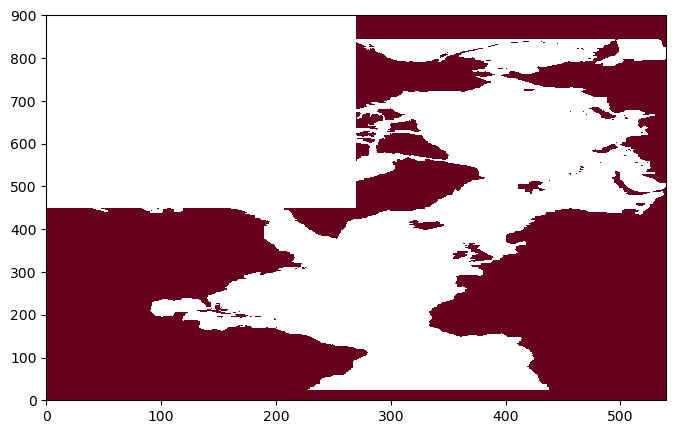

In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

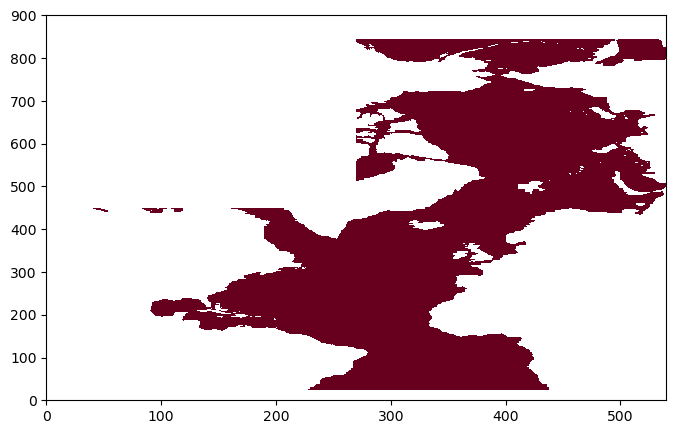

In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [6]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

# get the theta and salt profiles

In [10]:
print(np.cumsum(mygrid['DRF'])[0])
print(np.cumsum(mygrid['DRF'])[1:10])
print(np.cumsum(mygrid['DRF'])[11:])

10.0
[ 20.    30.    40.    50.    60.    70.    80.01  90.04 100.15]
[ 121.27  133.03  146.45  162.49  182.31  207.16  238.26  276.68  323.18
  378.18  441.68  513.26  592.16  677.31  767.49  861.45  958.03 1056.28
 1155.53 1255.54 1356.87 1461.43 1572.76 1695.59 1834.68 1993.62 2174.45
 2378.   2604.5  2854.   3126.5  3422.   3740.5  4082.   4446.5  4834.
 5244.5  5678.   6134.5 ]


In [19]:
idxS = 0
idxArW = np.arange(1,11,1)
idxAW = np.arange(11,50,1)

In [14]:
# set the lind mask

In [16]:
mymsk = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/mask_Lind.npz')
mymsk = mymsk['msk1']
msk1 = mymsk

In [28]:
mymsk = mygrid['hFacC'] * np.tile(mymsk[np.newaxis,:,:],(50,1,1))

# load the profiles and plot timeseries of avg annual temperature and salt for the three layers, also profiles

In [33]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_dist2 = np.zeros((len(allyears),12,nz))
salt_dist2 = np.zeros((len(allyears),12,nz))

# Initialize arrays to store time series data at specified depth indices
theta_idxS = np.zeros((len(allyears), 12))  # Single depth index (idxS)
theta_idxArW = np.zeros((len(allyears), 12))  # Multiple depth indices (idxArW)
theta_idxAW = np.zeros((len(allyears), 12))  # Multiple depth indices (idxAW)

salt_idxS = np.zeros((len(allyears), 12))
salt_idxArW = np.zeros((len(allyears), 12))
salt_idxAW = np.zeros((len(allyears), 12))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * msk1[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/mygrid['hFacC'] * msk1[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz

        # Extract mean values at specified depth indices
        theta_idxS[iy, i] = np.nanmean(thisTHETA[idxS, :, :])
        theta_idxArW[iy, i] = np.nanmean(thisTHETA[idxArW, :, :])
        theta_idxAW[iy, i] = np.nanmean(thisTHETA[idxAW, :, :])

        salt_idxS[iy, i] = np.nanmean(thisSALT[idxS, :, :])
        salt_idxArW[iy, i] = np.nanmean(thisSALT[idxArW, :, :])
        salt_idxAW[iy, i] = np.nanmean(thisSALT[idxAW, :, :])

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


Profiles saved to 'profiles.png'


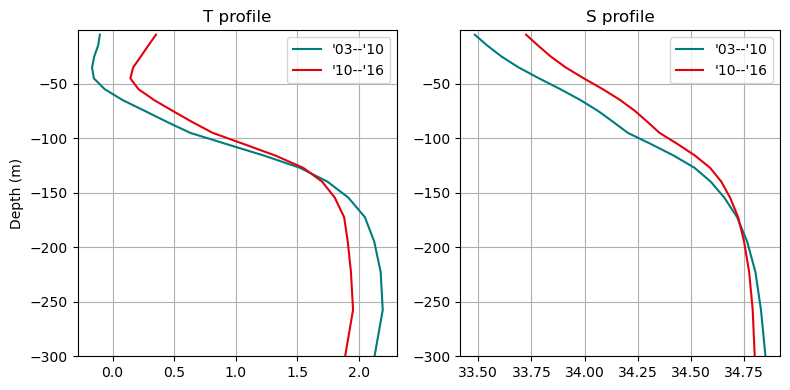

In [47]:
# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig = plt.figure(figsize=(8, 4))

# First plot: Temperature profile for Southern portion
ax = plt.subplot(121)
ax.plot(np.nanmean(theta_dist1[:8], axis=(0,1)), mygrid['RC'], label="'03--'10",color=c1)
ax.plot(np.nanmean(theta_dist1[8:-1], axis=(0,1)), mygrid['RC'], label="'10--'16",color=c3)
ax.set_ylim(-300, -1)
ax.set_title("T profile")
ax.legend()
ax.grid()
ax.set_ylabel("Depth (m)")  # Y-axis label

ax = plt.subplot(122)
# Second plot: Salinity profile for Southern portion
ax.plot(np.nanmean(salt_dist1[:8], axis=(0,1)), mygrid['RC'], label="'03--'10",color=c1)
ax.plot(np.nanmean(salt_dist1[8:-1], axis=(0,1)), mygrid['RC'], label="'10--'16",color=c3)
ax.set_ylim(-300, -1)
ax.set_title("S profile")
ax.legend()
ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("figs/profiles_100m.png", dpi=300)

print("Profiles saved to 'profiles.png'")

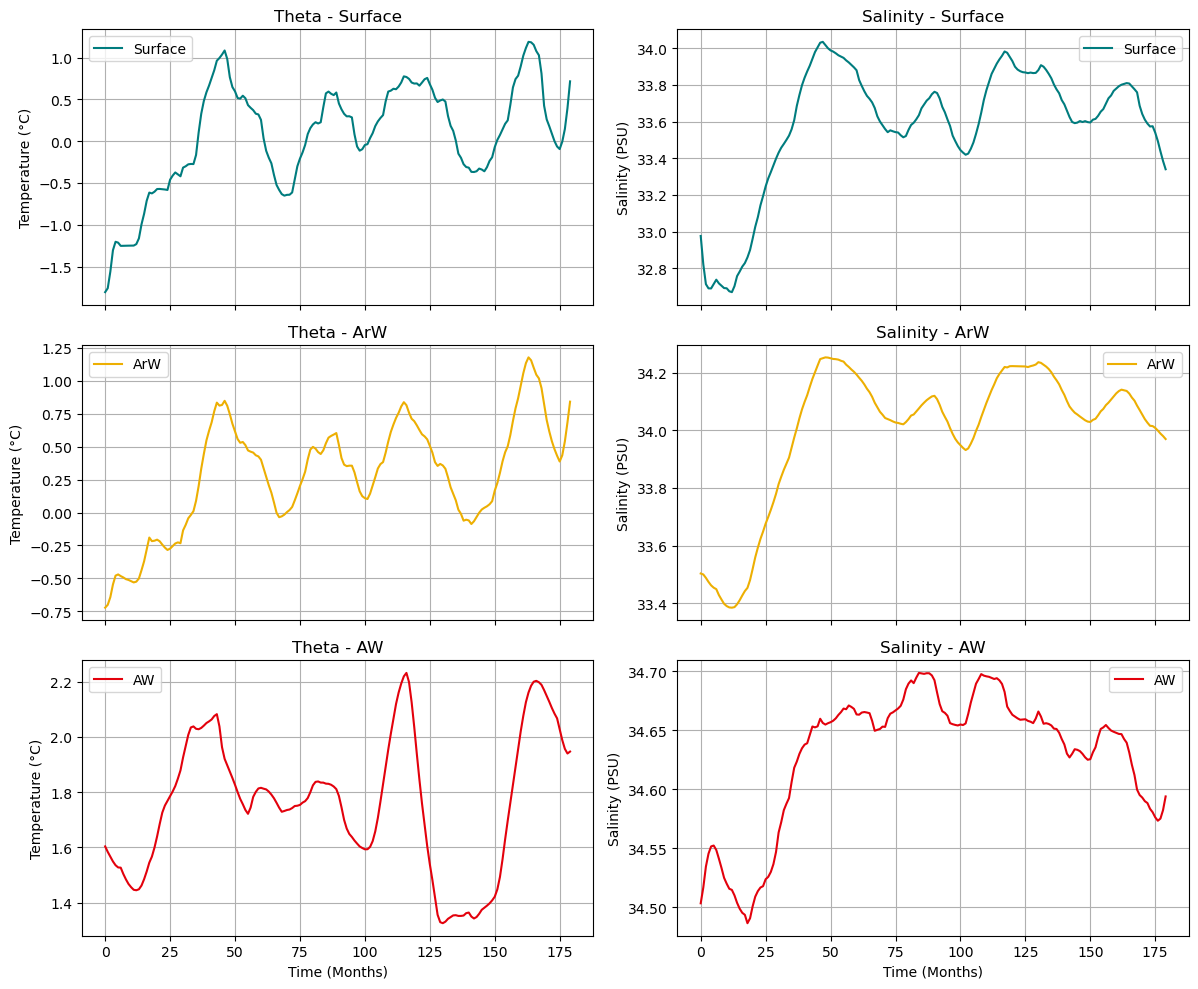

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define colors
c1 = '#007c7e'  # First color
c2 = '#edaf02'  # Second color
c3 = '#e3010c'  # Third color

# Define window size for smoothing
window_size = 12  # Adjust as needed for rolling mean

# Smooth time series for theta
theta_smooth_S = pd.Series(theta_idxS.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
theta_smooth_ArW = pd.Series(theta_idxArW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
theta_smooth_AW = pd.Series(theta_idxAW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values

# Smooth time series for salt
salt_smooth_S = pd.Series(salt_idxS.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
salt_smooth_ArW = pd.Series(salt_idxArW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
salt_smooth_AW = pd.Series(salt_idxAW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values

# Generate time axis (assuming monthly data over years)
time_axis = np.arange(len(theta_smooth_S))

# Create figure with 4x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex='col')

### --- Plot Theta Time Series ---
axes[0, 0].plot(time_axis, theta_smooth_S, label="Surface", color=c1)
axes[0, 0].set_title("Theta - Surface")
axes[0, 0].set_ylabel("Temperature (°C)")
axes[0, 0].grid()
axes[0, 0].legend()

axes[1, 0].plot(time_axis, theta_smooth_ArW, label="ArW", color=c2)
axes[1, 0].set_title("Theta - ArW")
axes[1, 0].set_ylabel("Temperature (°C)")
axes[1, 0].grid()
axes[1, 0].legend()

axes[2, 0].plot(time_axis, theta_smooth_AW, label="AW", color=c3)
axes[2, 0].set_title("Theta - AW")
axes[2, 0].set_ylabel("Temperature (°C)")
axes[2, 0].grid()
axes[2, 0].legend()
axes[2, 0].set_xlabel("Time (Months)")

### --- Plot Salt Time Series ---
axes[0, 1].plot(time_axis, salt_smooth_S, label="Surface", color=c1)
axes[0, 1].set_title("Salinity - Surface")
axes[0, 1].set_ylabel("Salinity (PSU)")
axes[0, 1].grid()
axes[0, 1].legend()

axes[1, 1].plot(time_axis, salt_smooth_ArW, label="ArW", color=c2)
axes[1, 1].set_title("Salinity - ArW")
axes[1, 1].set_ylabel("Salinity (PSU)")
axes[1, 1].grid()
axes[1, 1].legend()

axes[2, 1].plot(time_axis, salt_smooth_AW, label="AW", color=c3)
axes[2, 1].set_title("Salinity - AW")
axes[2, 1].set_ylabel("Salinity (PSU)")
axes[2, 1].grid()
axes[2, 1].legend()
axes[2, 1].set_xlabel("Time (Months)")

# Adjust layout
plt.tight_layout()
plt.show()


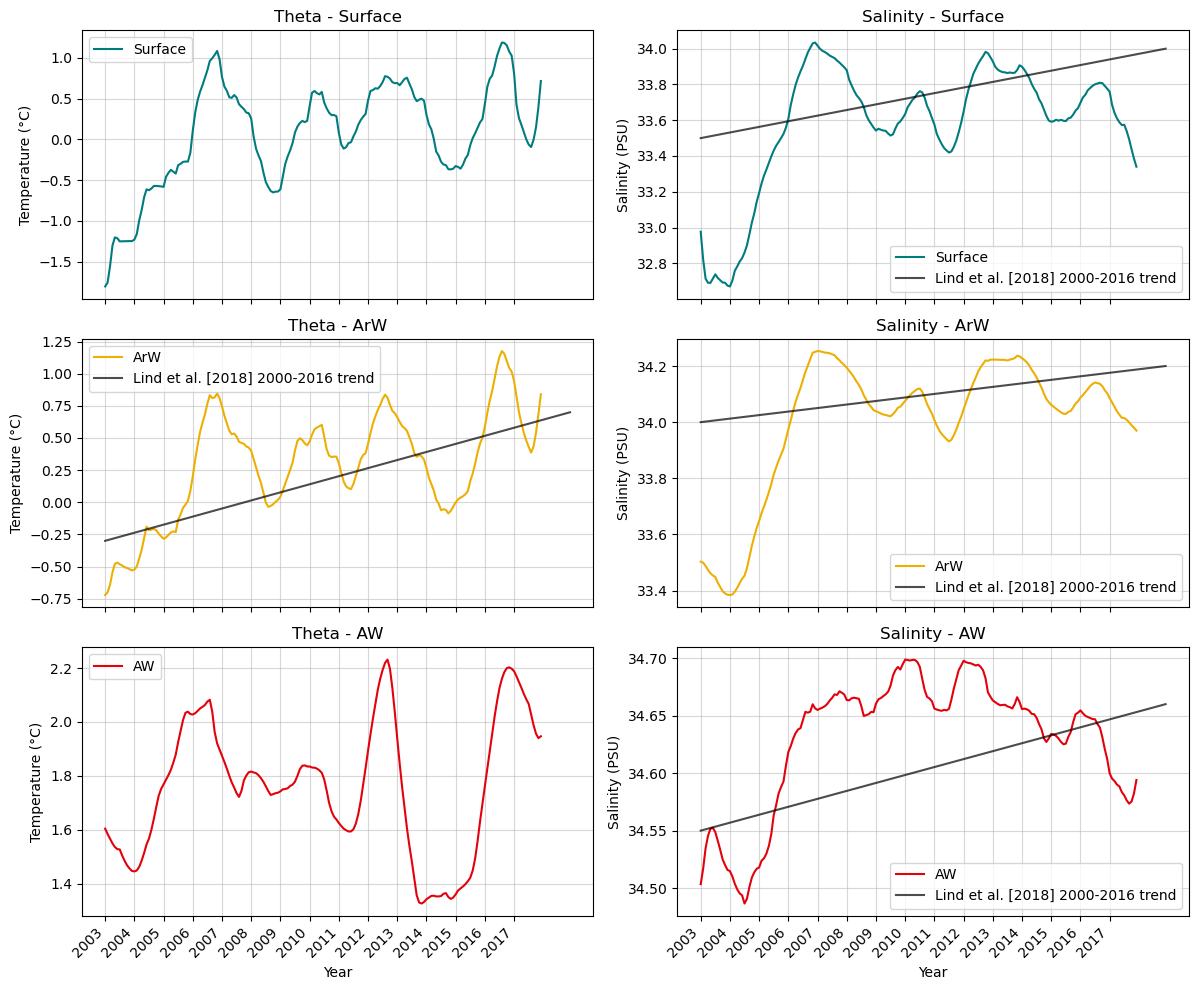

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define colors
c1 = '#007c7e'  # First color
c2 = '#edaf02'  # Second color
c3 = '#e3010c'  # Third color

# Define window size for smoothing
window_size = 12  # Adjust as needed for rolling mean

# Smooth time series for theta
theta_smooth_S = pd.Series(theta_idxS.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
theta_smooth_ArW = pd.Series(theta_idxArW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
theta_smooth_AW = pd.Series(theta_idxAW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values

# Smooth time series for salt
salt_smooth_S = pd.Series(salt_idxS.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
salt_smooth_ArW = pd.Series(salt_idxArW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
salt_smooth_AW = pd.Series(salt_idxAW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values

# Generate time axis: Months from January 2003 onward
start_year = 2003
num_months = len(theta_smooth_S)
years = np.arange(start_year, start_year + num_months // 12 + 1, 1)
months = np.arange(num_months)
xticks = np.arange(0, num_months, 12)  # Yearly ticks
xticklabels = [str(year) for year in years[:len(xticks)]]

# Create figure with 4x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

# Plot Theta Time Series
axes[0, 0].plot(months, theta_smooth_S, label="Surface", color=c1)
axes[0, 0].set_title("Theta - Surface")
axes[0, 0].set_ylabel("Temperature (°C)")
axes[0, 0].grid(alpha=0.5)
axes[0, 0].legend()

axes[1, 0].plot(months, theta_smooth_ArW, label="ArW", color=c2)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(-.3,.7,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[1,0].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
axes[1, 0].set_title("Theta - ArW")
axes[1, 0].set_ylabel("Temperature (°C)")
axes[1, 0].grid(alpha=0.5)
axes[1, 0].legend()

axes[2, 0].plot(months, theta_smooth_AW, label="AW", color=c3)
axes[2, 0].set_title("Theta - AW")
axes[2, 0].set_ylabel("Temperature (°C)")
axes[2, 0].grid(alpha=0.5)
axes[2, 0].legend()

# Plot Salt Time Series
axes[0, 1].plot(months, salt_smooth_S, label="Surface", color=c1)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(33.5,34,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[0,1].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
axes[0, 1].set_title("Salinity - Surface")
axes[0, 1].set_ylabel("Salinity (PSU)")
axes[0, 1].grid(alpha=0.5)
axes[0, 1].legend()

axes[1, 1].plot(months, salt_smooth_ArW, label="ArW", color=c2)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(34,34.2,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[1,1].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend")
axes[1, 1].set_title("Salinity - ArW")
axes[1, 1].set_ylabel("Salinity (PSU)")
axes[1, 1].grid(alpha=0.5)
axes[1, 1].legend()

axes[2, 1].plot(months, salt_smooth_AW, label="AW", color=c3)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(34.55,34.66,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[2,1].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend")
axes[2, 1].set_title("Salinity - AW")
axes[2, 1].set_ylabel("Salinity (PSU)")
axes[2, 1].grid(alpha=0.5)
axes[2, 1].legend()

# Set x-axis ticks to show years instead of months
for ax in axes[2, :]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=45,ha="right")
    ax.set_xlabel("Year")

# Adjust layout
plt.tight_layout()

plt.savefig("figs/Lindfig2_withcomparison.png",dpi=300)
plt.show()

In [ ]:
# add the lind trend to this

x_lind_fw = np.arange(-36,156) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind_fw = np.linspace(2.1,1.5,192)

slope = (y_lind_fw[-1] - y_lind_fw[0]) / (x_lind_fw[-1] - x_lind_fw[0])
print(slope)